# Back-and-Forth Demo
Synthetic example mixing smooth + nonsmooth mass to showcase the JAX implementation that mirrors Adaptive' back-and-forth solver.

In [1]:

# Environment + imports
import sys
from pathlib import Path
repo_root = str(Path.cwd().parents[1])
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from methods.back_and_forth.method import backnforth_sqeuclidean_nd
from methods.back_and_forth.pushforward import adaptive_pushforward_nd

sns.set_theme(style='whitegrid', context='talk')
jax.config.update('jax_enable_x64', True)
print('JAX ready:', jax.__version__)


JAX ready: 0.8.0


In [2]:
from methods.back_and_forth.monge_map import monge_map_from_psi_nd, index_to_unit

def _transport_map_unit(psi_array):
    psi_j = jnp.asarray(psi_array)
    T_idx = monge_map_from_psi_nd(psi_j)
    return np.array(index_to_unit(T_idx))

def plot_transport_map(psi_array, coords, title):
    '''Visualize each component of the Monge map as an image.'''
    T_unit = _transport_map_unit(psi_array)
    d = T_unit.shape[0]
    fig, axes = plt.subplots(1, d, figsize=(5 * d, 4))
    if d == 1:
        axes = [axes]
    titles = [fr'$T_{{{chr(120 + i)}}}$' for i in range(d)]
    for ax, comp, lbl in zip(axes, T_unit, titles):
        im = ax.imshow(comp, origin='lower', extent=(0, 1, 0, 1), cmap='viridis')
        ax.set_title(f"{title} {lbl}")
        ax.set_xticks([])
        ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    plt.tight_layout()
    plt.show()
    return T_unit

def plot_transport_graph(psi_array, coords, title, T_unit=None, max_points=8000):
    '''Scatter plot of coordinate pairs (x_i, T(x_i)) along each axis.'''
    if T_unit is None:
        T_unit = _transport_map_unit(psi_array)
    coords_np = [np.asarray(c) for c in coords]
    mesh = np.meshgrid(*coords_np, indexing='ij')
    flat_src = [m.ravel() for m in mesh]
    flat_tgt = [comp.ravel() for comp in T_unit]
    total = flat_src[0].size
    if total > max_points:
        step = max(1, total // max_points)
        idx = np.arange(0, total, step)
    else:
        idx = np.arange(total)
    d = len(coords_np)
    fig, axes = plt.subplots(1, d, figsize=(5 * d, 4))
    if d == 1:
        axes = [axes]
    coord_labels = [r'$x$', r'$y$', r'$z$']
    for i, (ax, src, tgt) in enumerate(zip(axes, flat_src, flat_tgt)):
        src_lbl = coord_labels[i] if i < len(coord_labels) else fr'$x_{{{i+1}}}$'
        tgt_lbl = fr'$T_{{{src_lbl.strip("$")}}}$' if src_lbl.startswith('$') else fr'$T_{{x_{i+1}}}$'
        ax.scatter(src[idx], tgt[idx], s=8, alpha=0.35, edgecolor='none')
        ax.set_xlabel(src_lbl)
        ax.set_ylabel(tgt_lbl)
        ax.set_xlim(coords_np[i][0], coords_np[i][-1])
        ax.set_ylim(coords_np[i][0], coords_np[i][-1])
        ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.7)
        ax.set_title(f"{title}: {tgt_lbl} vs {src_lbl}")
    plt.tight_layout()
    plt.show()

def plot_transport_quiver(psi_array, coords, title, T_unit=None, stride=6, scale=None):
    '''Plot displacement field T(x) - x as a quiver diagram (2D only).'''
    if T_unit is None:
        T_unit = _transport_map_unit(psi_array)
    coords_np = [np.asarray(c) for c in coords]
    if len(coords_np) != 2:
        print('Quiver plot is currently implemented for 2D grids only.')
        return T_unit
    X, Y = np.meshgrid(*coords_np, indexing='ij')
    U = T_unit[0] - X
    V = T_unit[1] - Y
    Xs = X[::stride, ::stride]
    Ys = Y[::stride, ::stride]
    Us = U[::stride, ::stride]
    Vs = V[::stride, ::stride]
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.quiver(Xs, Ys, Us, Vs, angles='xy', scale_units='xy', scale=scale, width=0.003, color='tab:blue')
    ax.set_title(f"{title} displacement field")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xlim(coords_np[0][0], coords_np[0][-1])
    ax.set_ylim(coords_np[1][0], coords_np[1][-1])
    ax.set_aspect('equal')
    ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.7)
    plt.tight_layout()
    plt.show()
    return T_unit


<>:33: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
<>:33: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_36694/3902946858.py:33: SyntaxWarning: "\m" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\m"? A raw string is also an option.
  ax[0].set_title('$\mu$ (source)')


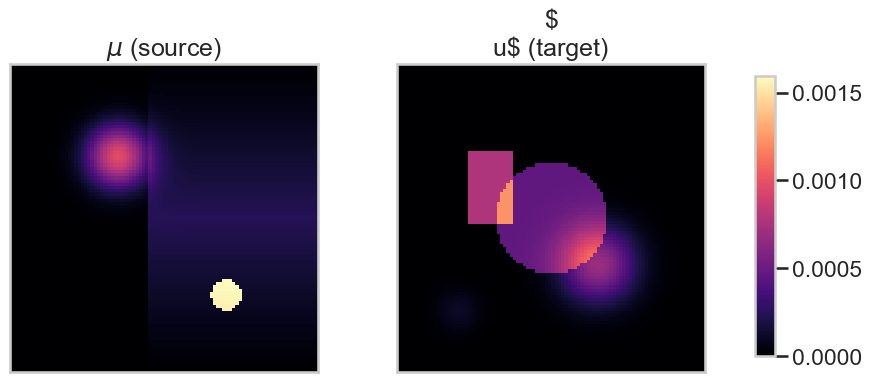

In [3]:

# Synthetic source/target densities (smooth + nonsmooth)
n1 = 96
n2 = 96
xs = np.linspace(0.5/n1, 1 - 0.5/n1, n1)
ys = np.linspace(0.5/n2, 1 - 0.5/n2, n2)
x, y = np.meshgrid(xs, ys)

def gaussian(cx, cy, scale):
    return np.exp(-((x - cx)**2 + (y - cy)**2) / scale)

mu_np = 0.8 * gaussian(0.35, 0.7, 0.01)
mu_np += 1.2 * (((x - 0.7)**2 + (y - 0.25)**2) < 0.05**2).astype(float)
mu_np += 0.2 * np.clip(1 - np.abs(2 * (y - 0.5)), 0, 1) * (x > 0.45)

nu_np = 0.9 * gaussian(0.65, 0.35, 0.015)
nu_np += 1.0 * (np.abs(x - 0.3) < 0.07) * (np.abs(y - 0.6) < 0.12)
nu_np += 0.6 * (((x - 0.5)**2 + (y - 0.5)**2) < 0.18**2).astype(float)
nu_np += 0.15 * gaussian(0.2, 0.2, 0.005)

mu_np = np.clip(mu_np, 0, None)
nu_np = np.clip(nu_np, 0, None)
mu_np /= np.sum(mu_np)
nu_np /= np.sum(nu_np)

mu = jax.device_put(mu_np)
nu = jax.device_put(nu_np)
coords = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vmin = min(mu_np.min(), nu_np.min())
vmax = max(mu_np.max(), nu_np.max())
im0 = ax[0].imshow(mu_np, origin='lower', extent=(0, 1, 0, 1), cmap='magma', vmin=vmin, vmax=vmax)
ax[0].set_title('$\mu$ (source)')
im1 = ax[1].imshow(nu_np, origin='lower', extent=(0, 1, 0, 1), cmap='magma', vmin=vmin, vmax=vmax)
ax[1].set_title('$\nu$ (target)')
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
fig.subplots_adjust(right=0.88, wspace=0.05)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im0, cax=cbar_ax)
plt.show()


In [4]:
stepsize = 4 / max(mu_np.max(), nu_np.max())
max_iter = 60
result = backnforth_sqeuclidean_nd(
    mu, nu, coords,
    stepsize=stepsize,
    maxiterations=max_iter,
    tolerance=1e-12,
    progressbar=False,
    pushforward_fn=adaptive_pushforward_nd,
    error_metric='h1_psi',
    )
(iterations, phi, psi, rho_nu, rho_mu, errors, dual_values, sigma_hist) = result
iterations = int(iterations)

print(f"Finished in {iterations} outer iterations")

Finished in 60 outer iterations


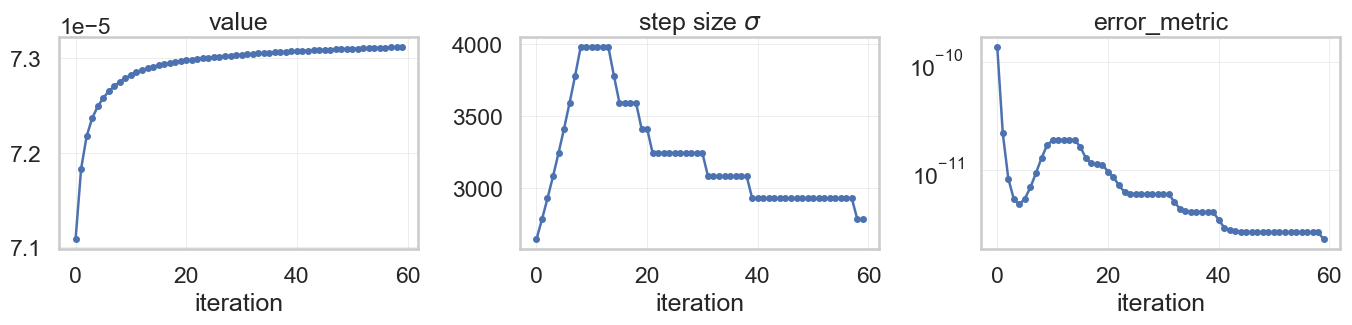

In [5]:

# Diagnostics: dual value, stepsize, and error evolution
metrics = {
    'value': np.array(dual_values[:iterations]),
    r'step size $\sigma$': np.array(sigma_hist[:iterations]),
    'error_metric': np.clip(np.array(errors[:iterations]), 1e-12, None),
}

fig, axes = plt.subplots(1, 3, figsize=(14, 3.6))
for ax, (title, data) in zip(axes, metrics.items()):
    ax.plot(np.arange(iterations), data, marker='o', linewidth=1.8, markersize=4)
    ax.set_title(title)
    ax.set_xlabel('iteration')
    if title == 'error_metric':
        ax.set_yscale('log')
    ax.grid(True, linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


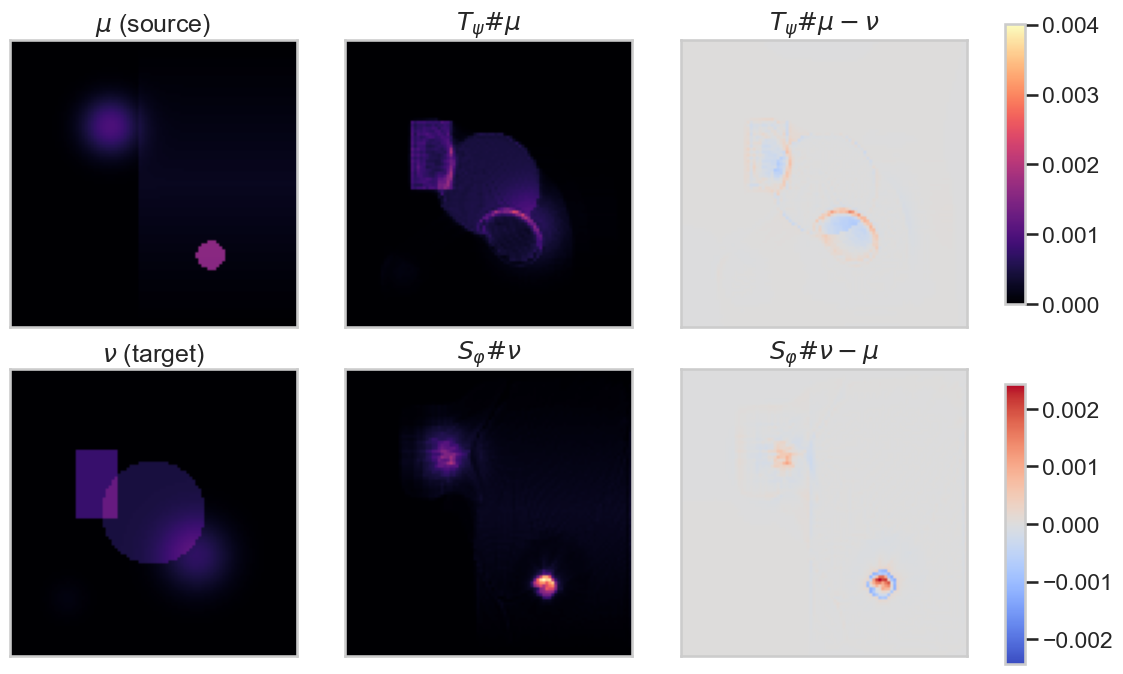

TV(T_psi#mu, nu) = 9.725e-02
TV(S_varphi#nu, mu) = 9.886e-02


In [6]:

# Compare pushforwards vs original measures
rho_mu_np = np.array(rho_mu)
rho_nu_np = np.array(rho_nu)
residual_mu = rho_mu_np - nu_np
residual_nu = rho_nu_np - mu_np

fig, axes = plt.subplots(2, 3, figsize=(13, 8))
vmin_main = min(mu_np.min(), nu_np.min(), rho_mu_np.min(), rho_nu_np.min())
vmax_main = max(mu_np.max(), nu_np.max(), rho_mu_np.max(), rho_nu_np.max())
res_max = max(np.abs(residual_mu).max(), np.abs(residual_nu).max())
entries = [
    (axes[0,0], mu_np, r'$\mu$ (source)', 'magma', True),
    (axes[0,1], rho_mu_np, r'$T_{\psi}\#\mu$', 'magma', True),
    (axes[0,2], residual_mu, r'$T_{\psi}\#\mu - \nu$', 'coolwarm', False),
    (axes[1,0], nu_np, r'$\nu$ (target)', 'magma', True),
    (axes[1,1], rho_nu_np, r'$S_{\varphi}\#\nu$', 'magma', True),
    (axes[1,2], residual_nu, r'$S_{\varphi}\#\nu - \mu$', 'coolwarm', False),
]
main_axes, res_axes = [], []
main_im, res_im = None, None
for ax, data, title, cmap, is_main in entries:
    if is_main:
        im = ax.imshow(data, origin='lower', extent=(0,1,0,1), cmap=cmap,
                       vmin=vmin_main, vmax=vmax_main)
        main_axes.append(ax)
        main_im = im
    else:
        im = ax.imshow(data, origin='lower', extent=(0,1,0,1), cmap=cmap,
                       vmin=-res_max, vmax=res_max)
        res_axes.append(ax)
        res_im = im
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
fig.subplots_adjust(right=0.88, wspace=0.08, hspace=0.15)
cbar_ax_main = fig.add_axes([0.9, 0.55, 0.015, 0.35])
cbar_ax_res = fig.add_axes([0.9, 0.1, 0.015, 0.35])
fig.colorbar(main_im, cax=cbar_ax_main)
fig.colorbar(res_im, cax=cbar_ax_res)
plt.show()

mu_tv = 0.5 * np.sum(np.abs(residual_nu))
nu_tv = 0.5 * np.sum(np.abs(residual_mu))
print(f"TV(T_psi#mu, nu) = {nu_tv:.3e}")
print(f"TV(S_varphi#nu, mu) = {mu_tv:.3e}")


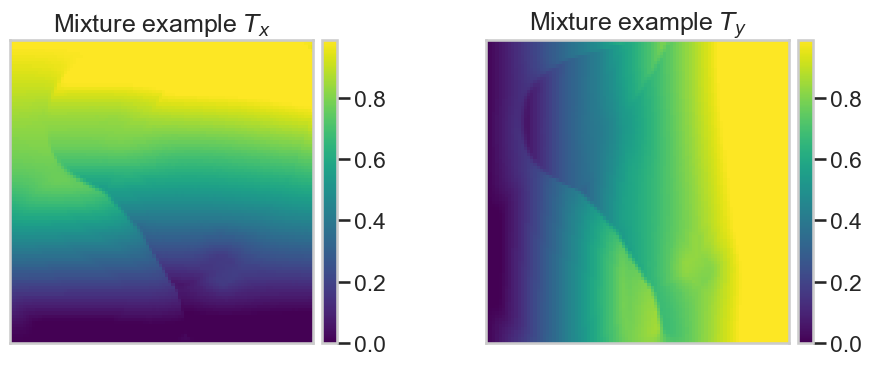

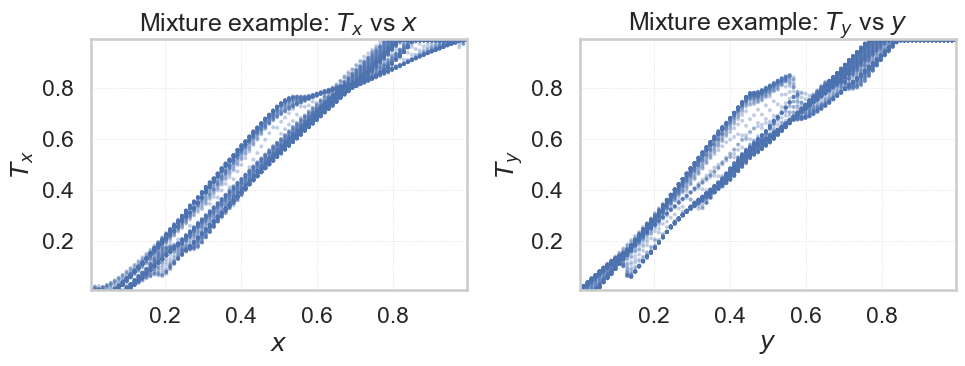

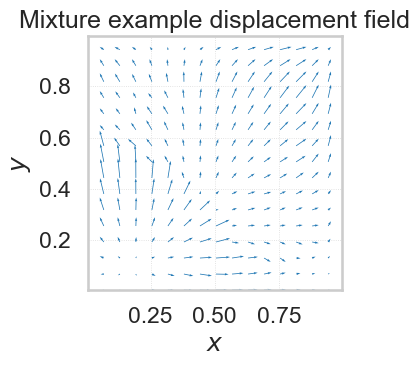

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.0054172 , 0.00893428],
        [0.00595705, 0.00541394, 0.00530127, ..., 0.        ,
         0.00178716, 0.01454876],
        [0.01122232, 0.010311  , 0.010311  , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.9858179 , 0.9858395 , 0.9858395 , ..., 0.98958333,
         0.97281333, 0.96129756],
        [0.98958333, 0.98958333, 0.98958333, ..., 0.97864385,
         0.97493732, 0.97404692],
        [0.98958333, 0.98958333, 0.98958333, ..., 0.98958333,
         0.98958333, 0.98958333]],

       [[0.01041667, 0.020946  , 0.03375503, ..., 0.98958333,
         0.98958333, 0.98958333],
        [0.01034548, 0.02079774, 0.0333658 , ..., 0.98958333,
         0.98958333, 0.98958333],
        [0.00933045, 0.02029023, 0.0326338 , ..., 0.98958333,
         0.98958333, 0.98958333],
        ...,
        [0.00903572, 0.02014286, 0.03231868, ..., 0.98958333,
         0.98958333, 0.98958333],
        [0.0

In [7]:
T_main = plot_transport_map(psi, coords, "Mixture example")
plot_transport_graph(psi, coords, "Mixture example", T_unit=T_main)
plot_transport_quiver(psi, coords, "Mixture example", T_unit=T_main)


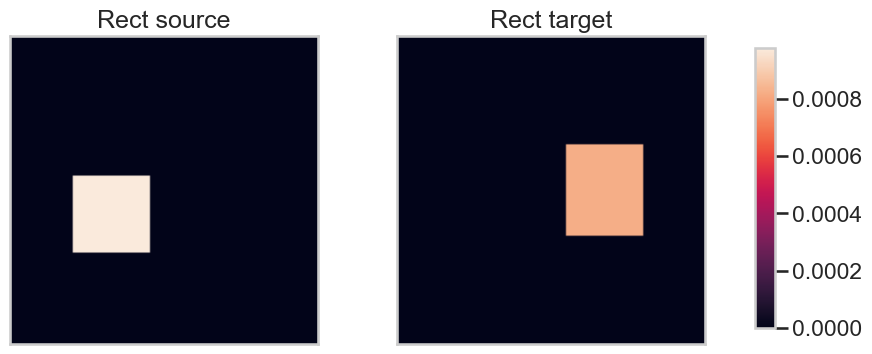

Rectangle example converged in 2 iterations


In [8]:

# Rectangle-to-rectangle transport (no scaling)
n1 = n2 = 128
xs = np.linspace(0.5/n1, 1-0.5/n1, n1)
ys = np.linspace(0.5/n2, 1-0.5/n2, n2)
x, y = np.meshgrid(xs, ys)

mu_rect = np.zeros_like(x)
mu_rect[(x > 0.2) & (x < 0.45) & (y > 0.3) & (y < 0.55)] = 1
nu_rect = np.zeros_like(x)
nu_rect[(x > 0.55) & (x < 0.8) & (y > 0.35) & (y < 0.65)] = 1

mu_rect /= mu_rect.sum()
nu_rect /= nu_rect.sum()

mu_rect_j = jax.device_put(mu_rect)
nu_rect_j = jax.device_put(nu_rect)
coords_rect = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vmin_rect = min(mu_rect.min(), nu_rect.min())
vmax_rect = max(mu_rect.max(), nu_rect.max())
im0 = ax[0].imshow(mu_rect, origin='lower', extent=(0,1,0,1), vmin=vmin_rect, vmax=vmax_rect)
ax[0].set_title('Rect source')
im1 = ax[1].imshow(nu_rect, origin='lower', extent=(0,1,0,1), vmin=vmin_rect, vmax=vmax_rect)
ax[1].set_title('Rect target')
for a in ax:
    a.set_xticks([]); a.set_yticks([])
fig.subplots_adjust(right=0.88, wspace=0.05)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im0, cax=cbar_ax)
plt.show()

result_rect = backnforth_sqeuclidean_nd(
    mu_rect_j, nu_rect_j, coords_rect,
    stepsize=stepsize, maxiterations=max_iter,
    tolerance=1e-10, pushforward_fn=adaptive_pushforward_nd,
    progressbar=False)
(it_rect, phi_rect, psi_rect, rho_mu_rect, rho_nu_rect, err_rect, dual_rect, sigma_rect) = result_rect
print(f"Rectangle example converged in {int(it_rect)} iterations")


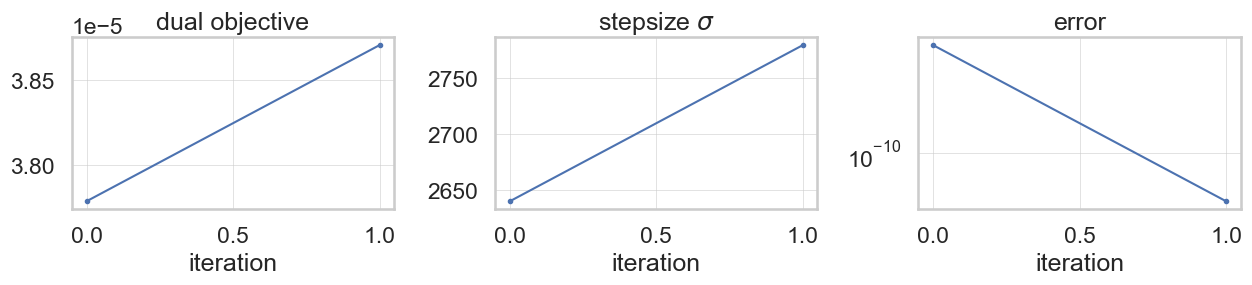

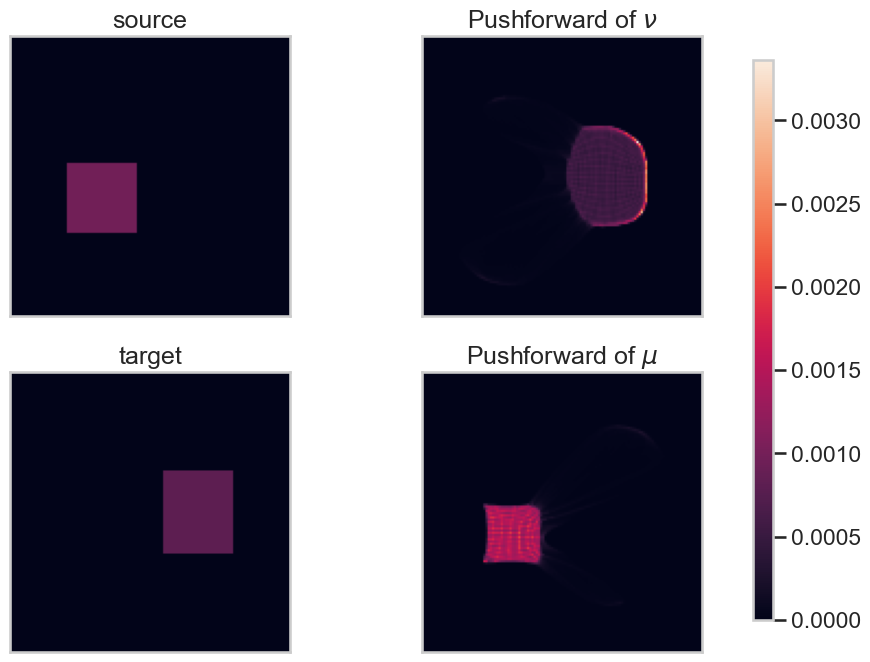

In [9]:

# Rectangle diagnostics
rect_metrics = {
    'dual objective': np.array(dual_rect[:it_rect]),
    r'stepsize $\sigma$': np.array(sigma_rect[:it_rect]),
    'error': np.clip(np.array(err_rect[:it_rect]), 1e-12, None)
}
fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))
for ax, (title, data) in zip(axes, rect_metrics.items()):
    ax.plot(np.arange(int(it_rect)), data, marker='o', linewidth=1.5, markersize=3)
    if title == 'error':
        ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('iteration')
    ax.grid(True, linewidth=0.4)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
vmin_rect = min(mu_rect.min(), nu_rect.min(), rho_mu_rect.min(), rho_nu_rect.min())
vmax_rect = max(mu_rect.max(), nu_rect.max(), rho_mu_rect.max(), rho_nu_rect.max())
data_list = [mu_rect, rho_nu_rect, nu_rect, rho_mu_rect]
titles = ['source', r'Pushforward of $\nu$', 'target', r'Pushforward of $\mu$']
for axi, data, title in zip(ax.flatten(), data_list, titles):
    im = axi.imshow(data, origin='lower', extent=(0,1,0,1), vmin=vmin_rect, vmax=vmax_rect)
    axi.set_title(title)
    axi.set_xticks([]); axi.set_yticks([])
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


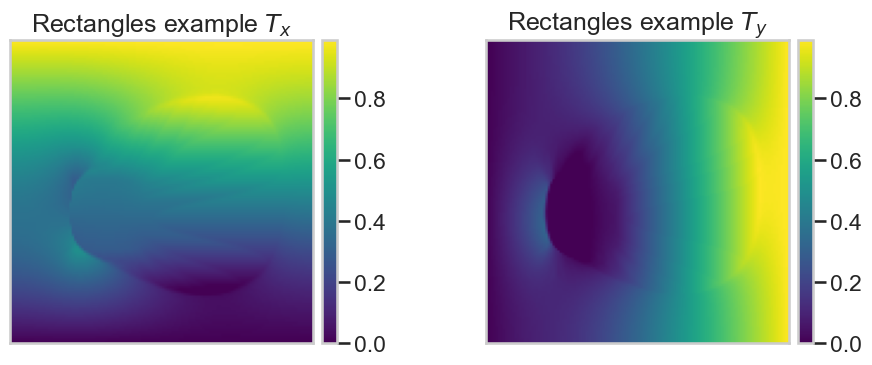

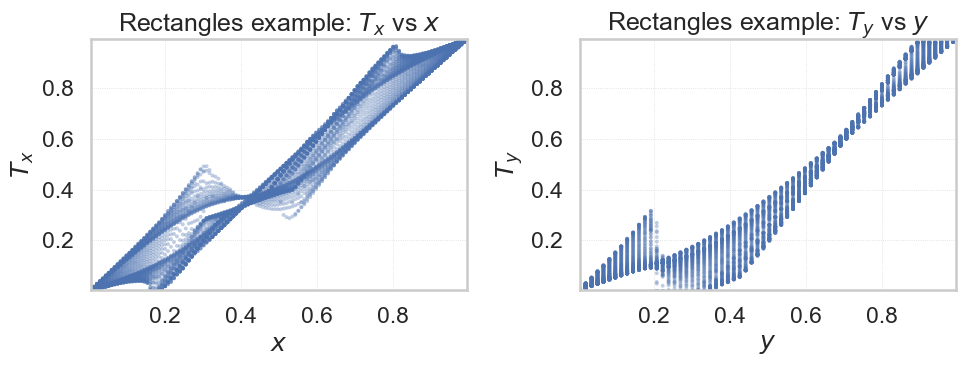

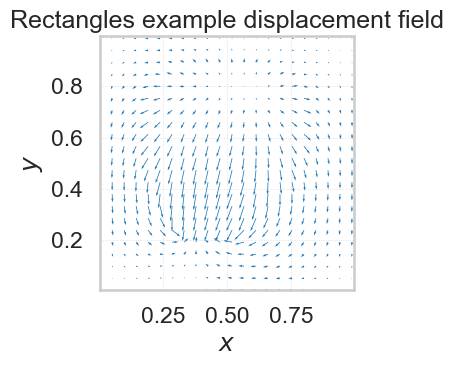

array([[[6.71703236e-03, 6.73464644e-03, 6.76660080e-03, ...,
         2.28095549e-04, 2.35918247e-04, 2.35918247e-04],
        [1.50772662e-02, 1.50860732e-02, 1.51020504e-02, ...,
         6.46359726e-03, 6.48052065e-03, 6.48052065e-03],
        [2.49122597e-02, 2.49227037e-02, 2.49403628e-02, ...,
         1.00683805e-02, 1.01114976e-02, 1.01114976e-02],
        ...,
        [9.74171961e-01, 9.74170803e-01, 9.74169721e-01, ...,
         9.86342379e-01, 9.86342379e-01, 9.86332283e-01],
        [9.84198212e-01, 9.84198191e-01, 9.84198149e-01, ...,
         9.91812769e-01, 9.91812769e-01, 9.91806551e-01],
        [9.92187500e-01, 9.92187500e-01, 9.92187500e-01, ...,
         9.92187500e-01, 9.92187500e-01, 9.92187500e-01]],

       [[1.25332953e-03, 7.96722991e-03, 1.32915670e-02, ...,
         9.74550177e-01, 9.84288770e-01, 9.92187500e-01],
        [1.27094361e-03, 7.99201413e-03, 1.33461209e-02, ...,
         9.74556285e-01, 9.84292681e-01, 9.92187500e-01],
        [1.27094361e-03, 

In [10]:
T_rect = plot_transport_map(psi_rect, coords_rect, "Rectangles example")
plot_transport_graph(psi_rect, coords_rect, "Rectangles example", T_unit=T_rect)
plot_transport_quiver(psi_rect, coords_rect, "Rectangles example", T_unit=T_rect)


/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_36694/3748265677.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


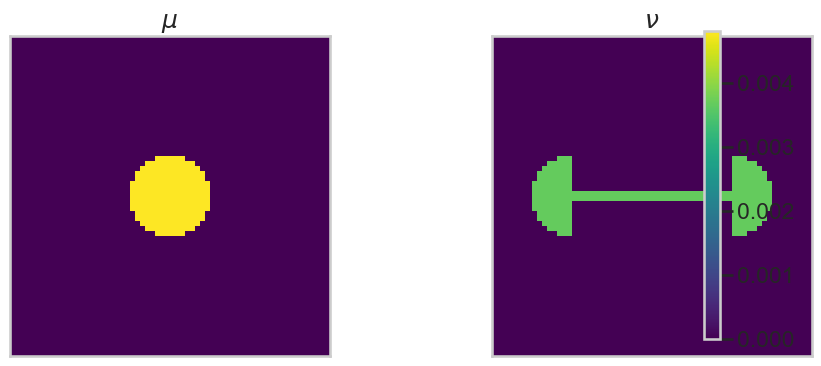

In [11]:
# Caffarelli counterexample (from example.ipynb)
# Grid of size n1 x n2
n1 = 64
n2 = 64
xs = np.linspace(0.5/n1, 1-0.5/n1, n1)
ys = np.linspace(0.5/n2, 1-0.5/n2, n2)
x, y = np.meshgrid(xs, ys)

phi_np = 0.5 * (x*x + y*y)
psi_np = 0.5 * (x*x + y*y)

mu_np = np.zeros((n2, n1))
r = 0.125
mu_np[(x-0.5)**2 + (y-0.5)**2 < r**2] = 1
nu_np = np.zeros((n2, n1))
idx = (((x-0.25)**2 + (y-0.5)**2 < r**2) & (x < 0.25))
idx = idx | (((x-0.75)**2 + (y-0.5)**2 < r**2) & (x > 0.75))
idx = idx | ((x < 0.751) & (x > 0.249) & (y < 0.51) & (y > 0.49))
nu_np[idx] = 1

mu_np /= np.sum(mu_np)
nu_np /= np.sum(nu_np)

mu = jax.device_put(mu_np)
nu = jax.device_put(nu_np)
coords = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vmin = min(mu_np.min(), nu_np.min())
vmax = max(mu_np.max(), nu_np.max())
im0 = ax[0].imshow(mu_np, origin='lower', extent=(0, 1, 0, 1), cmap='viridis', vmin=vmin, vmax=vmax)
ax[0].set_title(r"$\mu$")
im1 = ax[1].imshow(nu_np, origin='lower', extent=(0, 1, 0, 1), cmap='viridis', vmin=vmin, vmax=vmax)
ax[1].set_title(r"$\nu$")
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
fig.colorbar(im0, ax=ax.ravel().tolist(), fraction=0.045, pad=0.04)
plt.tight_layout()
plt.show()


In [12]:
result_caff = backnforth_sqeuclidean_nd(
    mu, nu, coords,
    stepsize=stepsize,
    maxiterations=max_iter,
    tolerance=1e-10,
    pushforward_fn=adaptive_pushforward_nd,
    progressbar=False,
)
(it_caff, phi_caff, psi_caff, rho_mu_caff, rho_nu_caff, err_caff, dual_caff, sigma_caff) = result_caff
print(f"Caffarelli example converged in {int(it_caff)} iterations")


Caffarelli example converged in 35 iterations


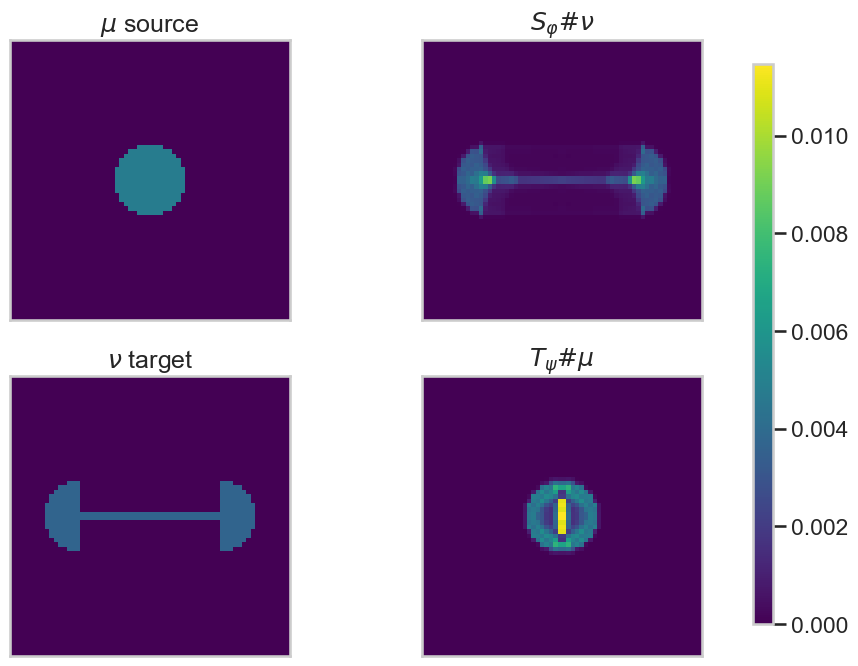

In [13]:

# Visualize pushforwards for Caffarelli case
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
vmin_c = min(mu_np.min(), nu_np.min(), rho_mu_caff.min(), rho_nu_caff.min())
vmax_c = max(mu_np.max(), nu_np.max(), rho_mu_caff.max(), rho_nu_caff.max())
entries = [
    (ax[0,0], mu_np, r'$\mu$ source'),
    (ax[0,1], rho_nu_caff, r'$S_{\varphi}\#\nu$'),
    (ax[1,0], nu_np, r'$\nu$ target'),
    (ax[1,1], rho_mu_caff, r'$T_{\psi}\#\mu$'),
]
for axi, data, title in entries:
    im = axi.imshow(data, origin='lower', extent=(0,1,0,1), cmap='viridis', vmin=vmin_c, vmax=vmax_c)
    axi.set_title(title)
    axi.set_xticks([])
    axi.set_yticks([])
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


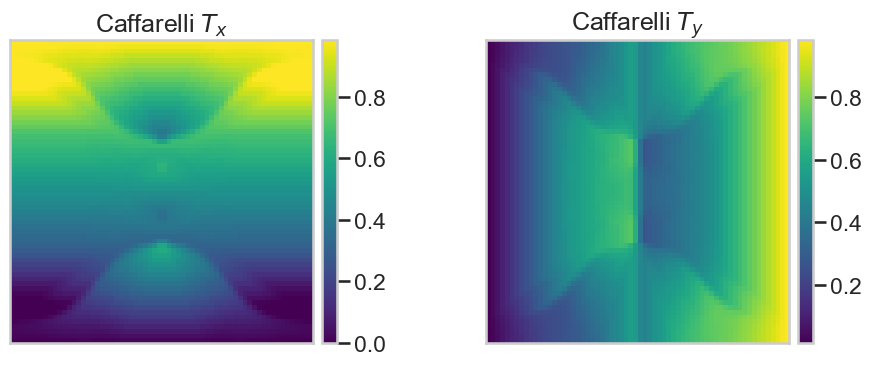

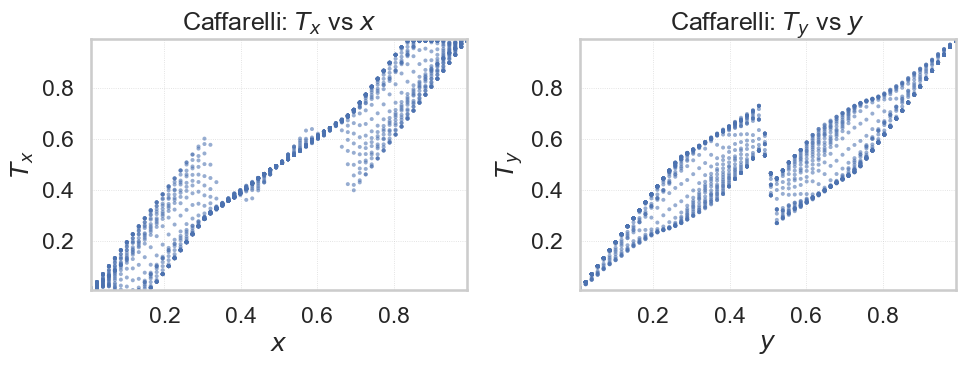

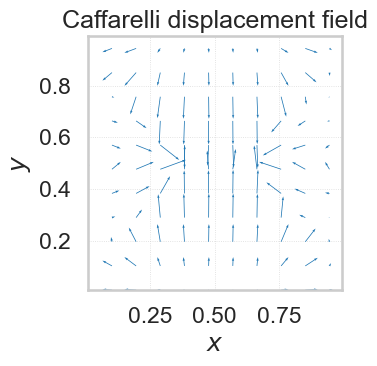

array([[[5.74189885e-05, 1.24774834e-04, 1.24774834e-04, ...,
         1.24774834e-04, 1.24774834e-04, 5.74189885e-05],
        [1.28885034e-02, 1.35545143e-02, 1.35545143e-02, ...,
         1.35545143e-02, 1.35545143e-02, 1.28885034e-02],
        [2.05348311e-02, 2.11771856e-02, 2.15586788e-02, ...,
         2.15586788e-02, 2.11771856e-02, 2.05348311e-02],
        ...,
        [9.79465169e-01, 9.78822814e-01, 9.78441321e-01, ...,
         9.78441321e-01, 9.78822814e-01, 9.79465169e-01],
        [9.84375000e-01, 9.84375000e-01, 9.84375000e-01, ...,
         9.84375000e-01, 9.84375000e-01, 9.84375000e-01],
        [9.84375000e-01, 9.84375000e-01, 9.84375000e-01, ...,
         9.84375000e-01, 9.84375000e-01, 9.84375000e-01]],

       [[1.42729352e-02, 3.05739676e-02, 4.80366440e-02, ...,
         9.51963356e-01, 9.69426032e-01, 9.84375000e-01],
        [1.43402910e-02, 3.06076455e-02, 4.81913676e-02, ...,
         9.51808632e-01, 9.69392354e-01, 9.84375000e-01],
        [1.56049571e-02, 

In [14]:
T_caff = plot_transport_map(psi_caff, coords, "Caffarelli")
plot_transport_graph(psi_caff, coords, "Caffarelli", T_unit=T_caff)
plot_transport_quiver(psi_caff, coords, "Caffarelli", T_unit=T_caff)


/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_36694/2151383569.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


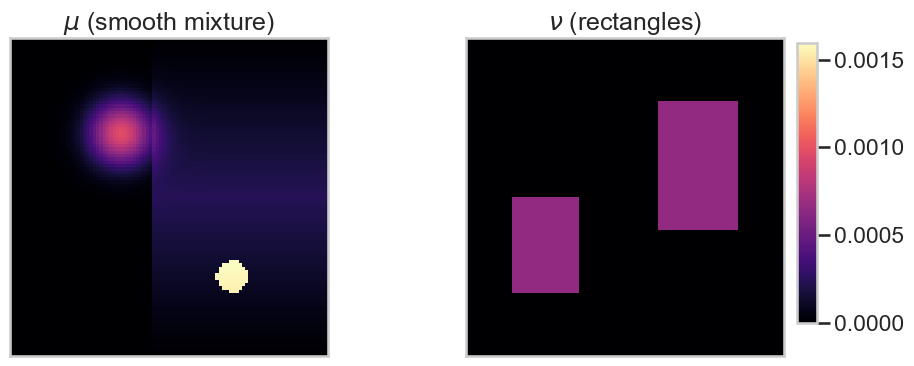

In [15]:

# Additional example: smooth vs discontinuous target (full-loop local solver)
n1 = 96
n2 = 96
xs = np.linspace(0.5/n1, 1 - 0.5/n1, n1)
ys = np.linspace(0.5/n2, 1 - 0.5/n2, n2)
x, y = np.meshgrid(xs, ys)

def gaussian(cx, cy, scale):
    return np.exp(-((x - cx)**2 + (y - cy)**2) / scale)

mu_cd = 0.8 * gaussian(0.35, 0.7, 0.01)
mu_cd += 1.2 * (((x - 0.7)**2 + (y - 0.25)**2) < 0.05**2).astype(float)
mu_cd += 0.2 * np.clip(1 - np.abs(2 * (y - 0.5)), 0, 1) * (x > 0.45)

nu_cd = np.zeros_like(x)
nu_cd[(x>0.15)&(x<0.35)&(y>0.2)&(y<0.5)] = 1
nu_cd[(x>0.6)&(x<0.85)&(y>0.4)&(y<0.8)] = 1

mu_cd = np.clip(mu_cd, 0, None)
nu_cd = np.clip(nu_cd, 0, None)
mu_cd /= np.sum(mu_cd)
nu_cd /= np.sum(nu_cd)

mu_cd_jax = jnp.asarray(mu_cd, dtype=jnp.float64)
nu_cd_jax = jnp.asarray(nu_cd, dtype=jnp.float64)
coords_cd = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vmin = min(mu_cd.min(), nu_cd.min())
vmax = max(mu_cd.max(), nu_cd.max())
im0 = ax[0].imshow(mu_cd, origin='lower', extent=(0,1,0,1), cmap='magma', vmin=vmin, vmax=vmax)
ax[0].set_title(r'$\mu$ (smooth mixture)')
im1 = ax[1].imshow(nu_cd, origin='lower', extent=(0,1,0,1), cmap='magma', vmin=vmin, vmax=vmax)
ax[1].set_title(r'$\nu$ (rectangles)')
for a in ax:
    a.set_xticks([]); a.set_yticks([])
fig.subplots_adjust(right=0.88, wspace=0.05)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im0, cax=cbar_ax)
plt.tight_layout()
plt.show()


In [16]:

stepsize_cd = 4 / max(mu_cd.max(), nu_cd.max())
result_cd = backnforth_sqeuclidean_nd(
    mu_cd_jax, nu_cd_jax, coords_cd,
    stepsize=stepsize_cd,
    maxiterations=80,
    tolerance=1e-10,
    progressbar=True,
    pushforward_fn=adaptive_pushforward_nd)
(iter_cd, phi_cd, psi_cd, rho_mu_cd, rho_nu_cd, err_cd, dual_cd, sigma_cd) = result_cd
iter_cd = int(iter_cd)
print(f"Smooth vs discontinuous example converged in {iter_cd} iterations")


[stepsize_update] gain = 3.930365268585016e-06; up = 7.189344846356714e-07; low = 2.3964482821189046e-07; sigma 2507.892304241753 -> 2639.8866360439506
[stepsize_update] gain = 1.3199506179647629e-06; up = 9.201510084120686e-08; low = 3.0671700280402285e-08; sigma 2639.8866360439506 -> 2778.8280379410003
Smooth vs discontinuous example converged in 2 iterations


/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_36694/70715936.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


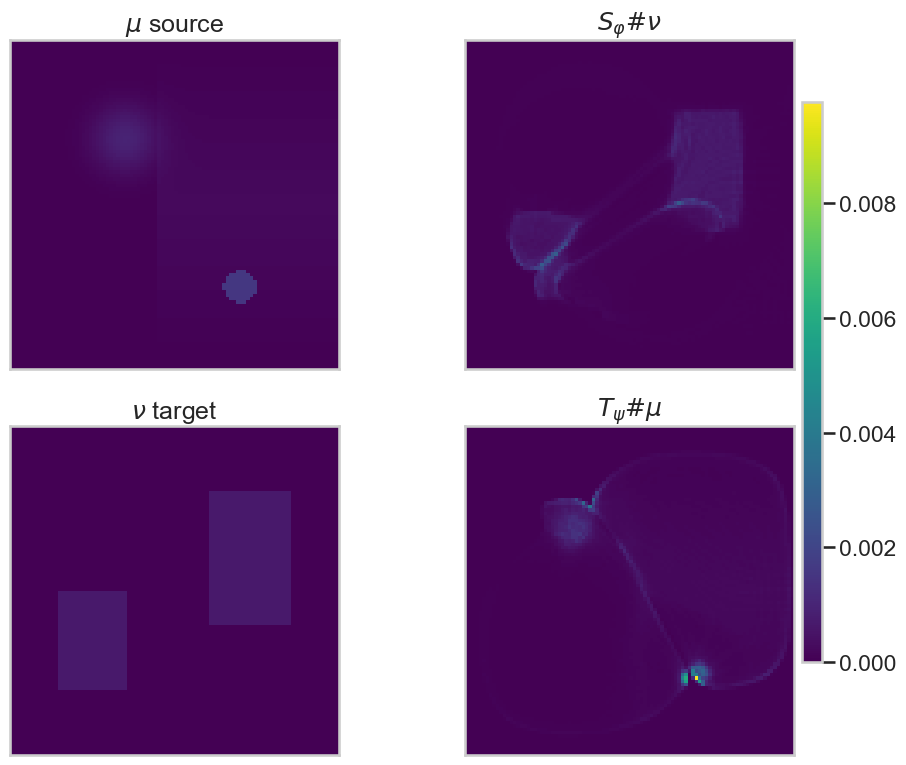

In [17]:

# Pushforward comparison for smooth/discontinuous example
vmin = min(mu_cd.min(), nu_cd.min(), np.min(rho_mu_cd), np.min(rho_nu_cd))
vmax = max(mu_cd.max(), nu_cd.max(), np.max(rho_mu_cd), np.max(rho_nu_cd))
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
entries = [
    (ax[0,0], mu_cd, r'$\mu$ source'),
    (ax[0,1], rho_nu_cd, r'$S_{\varphi}\#\nu$'),
    (ax[1,0], nu_cd, r'$\nu$ target'),
    (ax[1,1], rho_mu_cd, r'$T_{\psi}\#\mu$'),
]
for axi, data, lbl in entries:
    im = axi.imshow(data, origin='lower', extent=(0,1,0,1), cmap='viridis', vmin=vmin, vmax=vmax)
    axi.set_title(lbl)
    axi.set_xticks([]); axi.set_yticks([])
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()


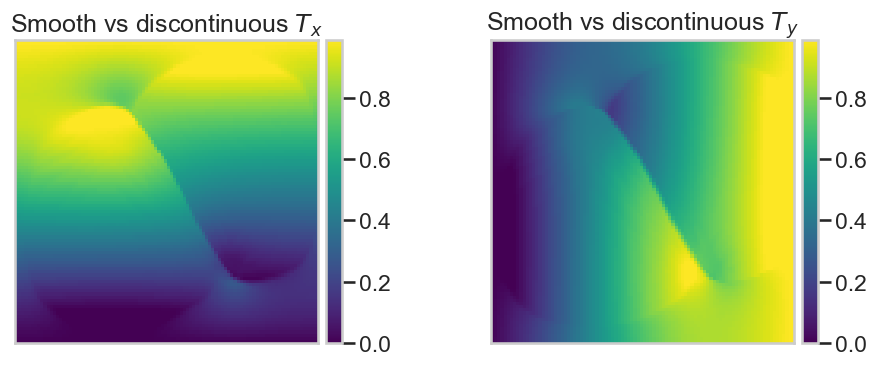

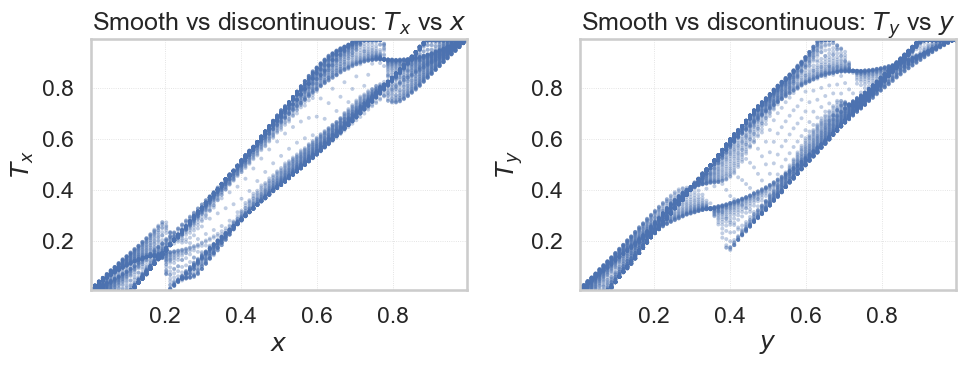

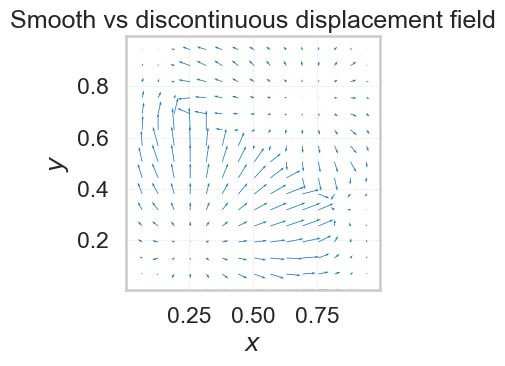

array([[[0.00265862, 0.00261963, 0.00261963, ..., 0.00781754,
         0.00780393, 0.00778339],
        [0.01076253, 0.01065187, 0.01051271, ..., 0.01953377,
         0.01952696, 0.0195167 ],
        [0.01828269, 0.0181626 , 0.01791031, ..., 0.03149082,
         0.03143622, 0.03140351],
        ...,
        [0.98227089, 0.98222262, 0.98222262, ..., 0.97158258,
         0.9713468 , 0.97124207],
        [0.98956047, 0.98952011, 0.98952011, ..., 0.98259474,
         0.9824592 , 0.98240544],
        [0.98958333, 0.98958333, 0.98958333, ..., 0.98958333,
         0.98958333, 0.98958333]],

       [[0.00775805, 0.01950402, 0.03134013, ..., 0.98216745,
         0.98940192, 0.98958333],
        [0.00771905, 0.01948453, 0.03127287, ..., 0.9821625 ,
         0.98938485, 0.98958333],
        [0.00753674, 0.0192542 , 0.03111083, ..., 0.9821625 ,
         0.98938485, 0.98958333],
        ...,
        [0.00874452, 0.01999726, 0.03259708, ..., 0.97859089,
         0.98716468, 0.98958333],
        [0.0

In [18]:
T_cd = plot_transport_map(psi_cd, coords_cd, "Smooth vs discontinuous")
plot_transport_graph(psi_cd, coords_cd, "Smooth vs discontinuous", T_unit=T_cd)
plot_transport_quiver(psi_cd, coords_cd, "Smooth vs discontinuous", T_unit=T_cd)


/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_36694/594053775.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


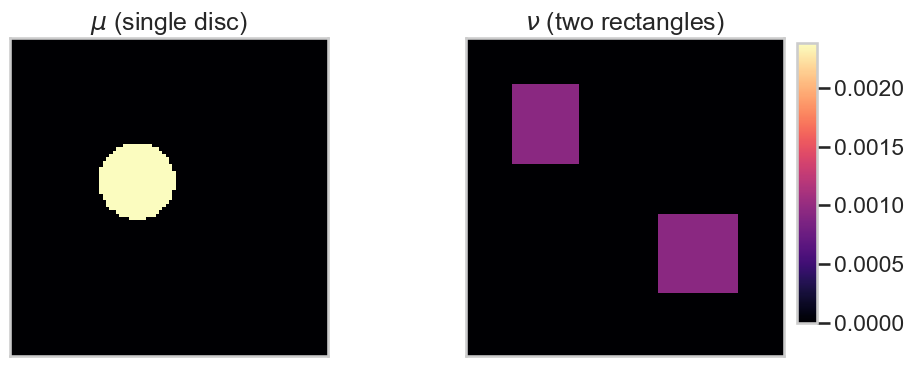

In [19]:

# Additional example: single-disc source vs. two-rectangle target
n1 = n2 = 96
xs = np.linspace(0.5/n1, 1 - 0.5/n1, n1)
ys = np.linspace(0.5/n2, 1 - 0.5/n2, n2)
x, y = np.meshgrid(xs, ys)

mu_disc = np.zeros_like(x)
mu_disc[((x-0.4)**2 + (y-0.55)**2) < 0.12**2] = 1

nu_rects = np.zeros_like(x)
nu_rects[(x>0.6)&(x<0.85)&(y>0.2)&(y<0.45)] = 1
nu_rects[(x>0.15)&(x<0.35)&(y>0.6)&(y<0.85)] = 1

mu_disc /= mu_disc.sum()
nu_rects /= nu_rects.sum()

mu_disc_jax = jnp.asarray(mu_disc, dtype=jnp.float64)
nu_rects_jax = jnp.asarray(nu_rects, dtype=jnp.float64)
coords_disc = [jnp.asarray(xs, dtype=jnp.float64), jnp.asarray(ys, dtype=jnp.float64)]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
vmin = min(mu_disc.min(), nu_rects.min())
vmax = max(mu_disc.max(), nu_rects.max())
im0 = ax[0].imshow(mu_disc, origin='lower', extent=(0,1,0,1), cmap='magma', vmin=vmin, vmax=vmax)
ax[0].set_title(r'$\mu$ (single disc)')
im1 = ax[1].imshow(nu_rects, origin='lower', extent=(0,1,0,1), cmap='magma', vmin=vmin, vmax=vmax)
ax[1].set_title(r'$\nu$ (two rectangles)')
for a in ax:
    a.set_xticks([]); a.set_yticks([])
fig.subplots_adjust(right=0.88, wspace=0.05)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im0, cax=cbar_ax)
plt.tight_layout()
plt.show()


In [20]:
stepsize_disc = 4 / max(mu_disc.max(), nu_rects.max())
res_disc = backnforth_sqeuclidean_nd(
    mu_disc_jax, nu_rects_jax, coords_disc,
    stepsize=stepsize_disc,
    maxiterations=80,
    tolerance=1e-12,
    progressbar=True,
    pushforward_fn=adaptive_pushforward_nd)
(iter_disc, phi_disc, psi_disc, rho_mu_disc, rho_nu_disc, err_disc, dual_disc, sigma_disc) = res_disc
# rho_mu_disc = rho_mu_disc[-1] if rho_mu_disc.size else np.zeros_like(mu_disc)
# rho_nu_disc = rho_nu_disc[-1] if rho_nu_disc.size else np.zeros_like(nu_rects)
print(f"Single-disc vs two-rectangle example converged in {int(iter_disc)} iterations")

[stepsize_update] gain = 7.433970230945242e-06; up = 1.942687073379112e-06; low = 6.475623577930373e-07; sigma 1679.9999999999998 -> 1768.4210526315785
[stepsize_update] gain = 1.1168165569862466e-06; up = 1.9548487522558648e-07; low = 6.51616250751955e-08; sigma 1768.4210526315785 -> 1861.4958448753457
[stepsize_update] gain = 2.6483919720874977e-07; up = 7.452260831796187e-08; low = 2.4840869439320625e-08; sigma 1861.4958448753457 -> 1959.4693103951006
[stepsize_update] gain = 2.272378392980572e-07; up = 7.658221293017343e-08; low = 2.552740431005781e-08; sigma 1959.4693103951006 -> 2062.599274100106
[stepsize_update] gain = 1.291836311070497e-07; up = 1.0119669266693889e-07; low = 3.373223088897963e-08; sigma 2062.599274100106 -> 2171.1571306316905
[stepsize_update] gain = 1.3255957664339534e-07; up = 1.3493291447013027e-07; low = 4.4977638156710086e-08; sigma 2171.1571306316905 -> 2171.1571306316905
[stepsize_update] gain = 1.1356789634480813e-07; up = 1.5198193459807288e-07; low =

/var/folders/zt/h5ncncv1043cdpswcj8nysgm0000gn/T/ipykernel_36694/1687741539.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


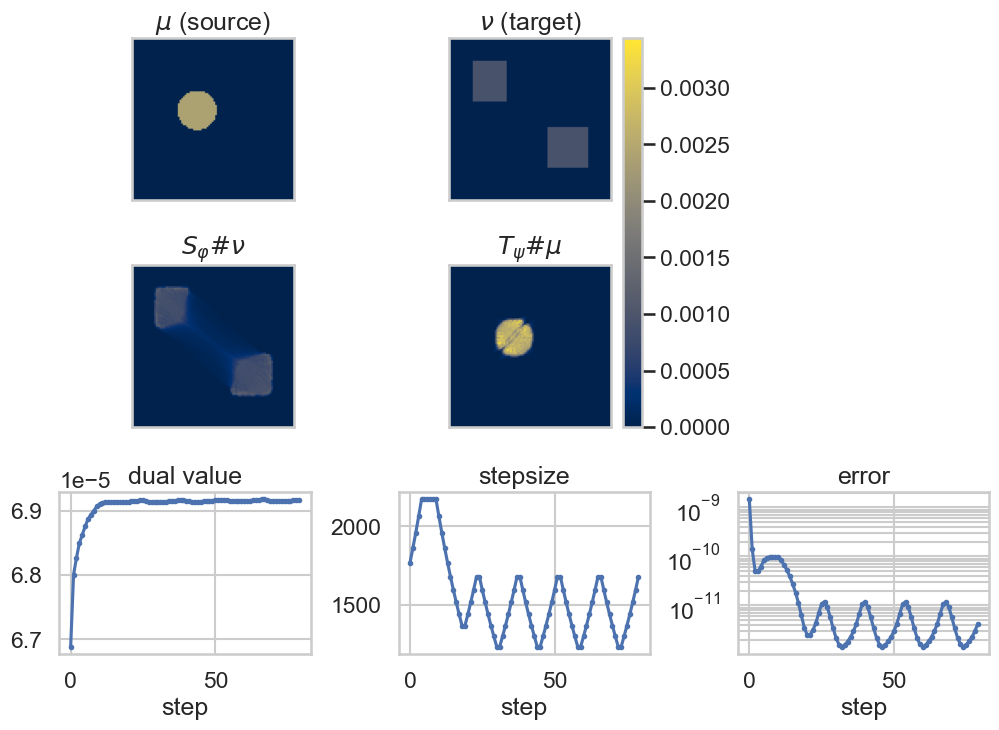

In [21]:

fig = plt.figure(figsize=(12, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 3, height_ratios=[1,1,1], hspace=0.4, wspace=0.35)

vmin = min(mu_disc.min(), nu_rects.min(), rho_mu_disc.min(), rho_nu_disc.min())
vmax = max(mu_disc.max(), nu_rects.max(), rho_mu_disc.max(), rho_nu_disc.max())
axes = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]
entries = [
    (axes[0], mu_disc, r'$\mu$ (source)'),
    (axes[1], nu_rects, r'$\nu$ (target)'),
    (axes[2], rho_nu_disc, r'$S_{\varphi}\#\nu$'),
    (axes[3], rho_mu_disc, r'$T_{\psi}\#\mu$'),
]
for ax, data, title in entries:
    im = ax.imshow(data, origin='lower', extent=(0,1,0,1), cmap='cividis', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
fig.colorbar(im, ax=axes, fraction=0.046, pad=0.02)

ax_dual = fig.add_subplot(gs[2,0])
ax_sigma = fig.add_subplot(gs[2,1])
ax_err = fig.add_subplot(gs[2,2])
ax_dual.plot(dual_disc, '-o', markersize=3); ax_dual.set_title('dual value'); ax_dual.set_xlabel('step'); ax_dual.grid(True)
ax_sigma.plot(sigma_disc, '-o', markersize=3); ax_sigma.set_title('stepsize'); ax_sigma.set_xlabel('step'); ax_sigma.grid(True)
ax_err.plot(np.clip(err_disc, 1e-12, None), '-o', markersize=3); ax_err.set_yscale('log'); ax_err.set_title('error'); ax_err.set_xlabel('step'); ax_err.grid(True, which='both')
plt.tight_layout()
plt.show()


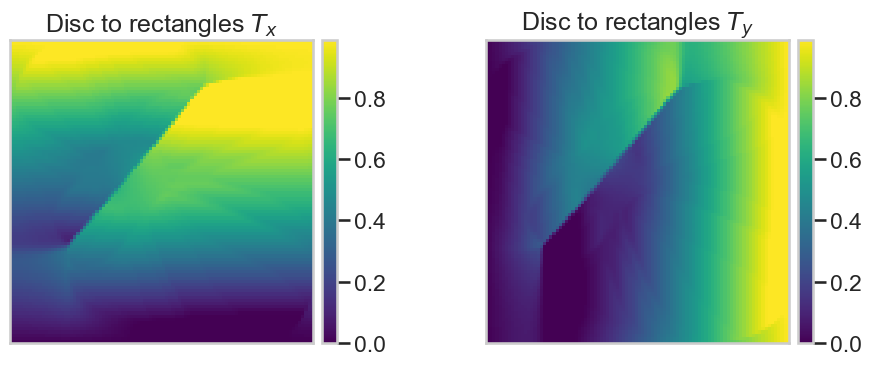

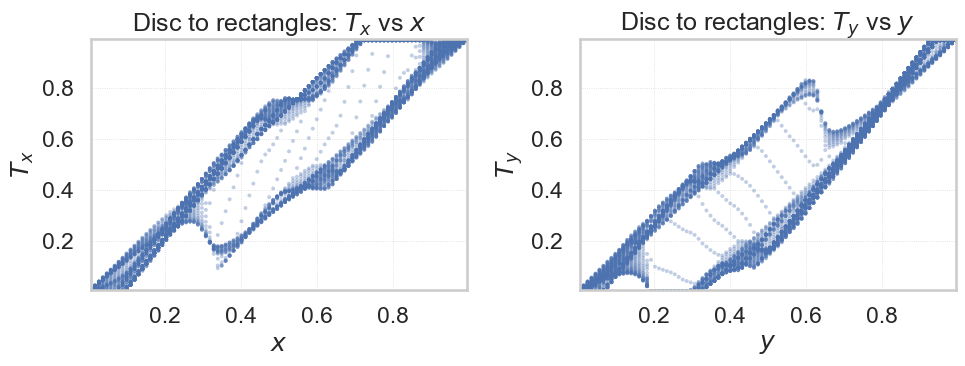

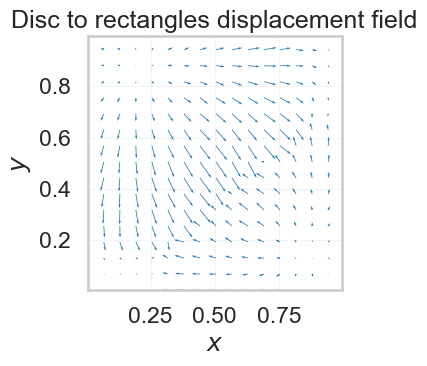

array([[[0.00834733, 0.00839097, 0.00848433, ..., 0.        ,
         0.        , 0.        ],
        [0.01979867, 0.01982049, 0.01986716, ..., 0.00694168,
         0.00694168, 0.00720496],
        [0.03173699, 0.03177806, 0.0318486 , ..., 0.01223904,
         0.01223904, 0.01259259],
        ...,
        [0.97197894, 0.97216658, 0.97254246, ..., 0.98952065,
         0.98958333, 0.98958333],
        [0.98326249, 0.98337517, 0.9836007 , ..., 0.98958333,
         0.98958333, 0.98958333],
        [0.98958333, 0.98958333, 0.98958333, ..., 0.98958333,
         0.98958333, 0.98958333]],

       [[0.00235975, 0.01093724, 0.01842557, ..., 0.9673798 ,
         0.97992162, 0.98958333],
        [0.0024034 , 0.01100574, 0.01851236, ..., 0.96747458,
         0.98000586, 0.98958333],
        [0.0024034 , 0.01100574, 0.01851236, ..., 0.96817234,
         0.9801849 , 0.98958333],
        ...,
        [0.00426634, 0.01424941, 0.02387403, ..., 0.96636519,
         0.97921323, 0.98958333],
        [0.0

In [22]:
T_disc = plot_transport_map(psi_disc, coords_disc, "Disc to rectangles")
plot_transport_graph(psi_disc, coords_disc, "Disc to rectangles", T_unit=T_disc)
plot_transport_quiver(psi_disc, coords_disc, "Disc to rectangles", T_unit=T_disc)
